In [0]:
pip install livelossplot

In [0]:
pip uninstall tensorflow

In [0]:
pip install tensorflow-gpu

In [0]:
pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


# **Headers**

In [0]:
import scipy.io
import os
import shutil
import cv2
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import keras
import numpy as np
import cv2
import glob
import random
import datetime

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.engine.saving import load_model
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as kb
import tensorflow as tf
from livelossplot.keras import PlotLossesCallback

from google.colab.patches import cv2_imshow

MAIN_DIR_PATH = "drive/My Drive/Car Classifier/"
LOGS = MAIN_DIR_PATH + "/logs"
IMG_SHAPE = (224, 224)  # (454, 313, 3)
NUM_OF_CLASSES = 1349

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Loader Function Definitions**

In [0]:
def preprocess_image(img, img_shape):
    img = cv2.resize(img, img_shape)
    img = np.array(img, dtype=np.float64)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    return img

def get_data_frames(csv_training_path, csv_validation_path, csv_test_path):
    training_df = pd.read_csv(csv_training_path)
    validation_df = pd.read_csv(csv_validation_path)
    test_df = pd.read_csv(csv_test_path)

    return training_df, validation_df, test_df


def get_generators(images_directory, training_df, validation_df, test_df):
    datagen = ImageDataGenerator(rescale=1. / 255)
    training_generator = datagen.flow_from_dataframe(dataframe=training_df,
                                                     directory=images_directory,
                                                     x_col="filename",
                                                     y_col="label",
                                                     target_size=IMG_SHAPE,
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     class_mode="categorical")

    validation_generator = datagen.flow_from_dataframe(dataframe=validation_df,
                                                       directory=images_directory,
                                                       x_col="filename",
                                                       y_col="label",
                                                       target_size=IMG_SHAPE,
                                                       color_mode='rgb',
                                                       batch_size=64,
                                                       class_mode="categorical")

    test_generator = datagen.flow_from_dataframe(dataframe=test_df,
                                                 directory=images_directory,
                                                 x_col="filename",
                                                 y_col="label",
                                                 target_size=IMG_SHAPE,
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode="categorical")

    return training_generator, validation_generator, test_generator

# **Model Function Definitions**

In [0]:
def get_model(number_of_classes):
    base_model = keras.applications.MobileNet(weights='imagenet',
                                              include_top=False,
                                              input_shape=(224,224, 3))

    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(1024, activation='relu',kernel_initializer='random_uniform', bias_initializer='zeros')(x)
    x = keras.layers.BatchNormalization()(x)
    prediction = keras.layers.Dense(number_of_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=base_model.input, outputs=prediction)

    return model

# **Training Function Definitions**

In [0]:
def train_model(training_generator, validation_generator, model_name="xception_model", augment=False, lr=1e-4,
                epochs=10, early_stop=False, fine_tune_from=-1, num_of_classes=2, model=None):
    """
    Returns a trained model and the training history.

    :param training_generator: the training data generator
    :param validation_generator: the validation data generator
    :param augment: whether or not the augment the data
    :param model_name: name of the new model (weights will be saved under this name)
    :param lr: learning rate for model
    :param epochs: number of epochs to run for
    :param early_stop: whether or not to stop early if the validation and training curves diverge too much
    :param fine_tune_from: which layer to start fine tuning from (all layers before this layer will be frozen)
    :param num_of_classes: number of classes the model should output
    :param model: an existing model to train
    """

    if model is None:
        model = get_model(num_of_classes)

    # Fine Tuning
    if fine_tune_from >= 0:
      print(len(model.layers))
      for layer in model.layers:
          layer.trainable = False

      for layer in model.layers[fine_tune_from:]:
          layer.trainable = True

    # keras.optimizers.SGD(lr=0.01, dmomentum=0.9, nesterov=True)
    model.compile(optimizer=keras.optimizers.Adam(lr=lr),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])

    # Setup training callbacks
    callbacks = []
    if early_stop:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=40))
    callbacks.append(keras.callbacks.ModelCheckpoint(MAIN_DIR_PATH + "/" + model_name + ".h5", save_best_only=True))
    callbacks.append(PlotLossesCallback())

    model.summary()

    train_step_size = training_generator.n // training_generator.batch_size
    history = model.fit_generator(training_generator, validation_data=validation_generator,
                                  epochs=epochs, steps_per_epoch=train_step_size,
                                  callbacks=callbacks)

    return model, history

# Run

In [54]:
# Load data into generators
training_df, validation_df, test_df = get_data_frames(MAIN_DIR_PATH + "data/bmw_training_data.csv", 
                                                      MAIN_DIR_PATH + "data/bmw_validation_data.csv",
                                                      MAIN_DIR_PATH + "data/bmw_test_data.csv")
training_generator, validation_generator, test_generator = get_generators(MAIN_DIR_PATH, training_df, validation_df, test_df)

Found 3632 validated image filenames belonging to 146 classes.
Found 908 validated image filenames belonging to 146 classes.
Found 908 validated image filenames belonging to 146 classes.


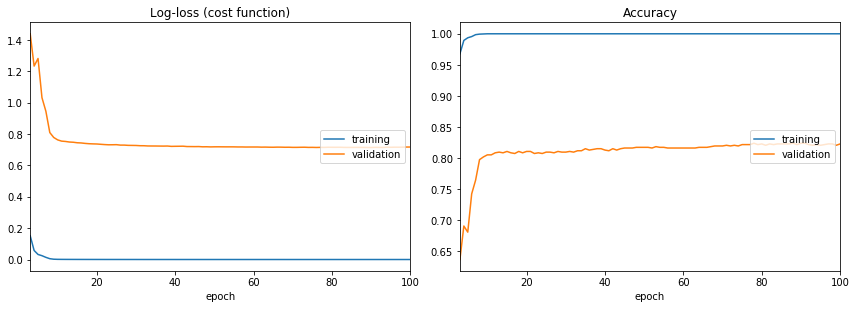

Log-loss (cost function):
training   (min:    0.000, max:    3.162, cur:    0.000)
validation (min:    0.714, max:    4.226, cur:    0.717)

Accuracy:
training   (min:    0.339, max:    1.000, cur:    1.000)
validation (min:    0.248, max:    0.824, cur:    0.823)


In [97]:
# Train model
#loaded_model = load_model(MAIN_DIR_PATH + "make_model3.h5")
model, history = train_model(training_generator, validation_generator, model_name="bmw_model", augment=False,
                              lr=1e-3, epochs=100, early_stop=True, fine_tune_from=0, 
                             num_of_classes=146, model=None)

# **Test**

In [0]:
model.save_weights(MAIN_DIR_PATH + "/" + "bmw_model_weights" + ".hdf5")

In [0]:
# Load Car Make model
tester_model = keras.models.load_model(MAIN_DIR_PATH + "bmw_model.h5")

In [116]:
#img = cv2.imread(MAIN_DIR_PATH + "data/image/81/100/2012/0af9d24865feaa.jpg") 
img = cv2.imread(MAIN_DIR_PATH + "data/test/2015_BMW_i8.jpg") 
r_img = preprocess_image(img, IMG_SHAPE)

result = tester_model.predict(r_img)
probs = np.argsort(-result)[:1].flatten()

#label_map = {0: 'Acura', 1: 'Aston Martin', 2: 'Audi', 3: 'BWM', 4: 'Bentley', 5: 'Benz', 6: 'Bugatti', 7: 'Ferrari', 8: 'Jaguar', 9: 'Lamorghini ', 10: 'Maserati', 11: 'McLaren', 12: 'Mustang', 13: 'Porsche', 14: 'TESLA'}
#label_map = {0: 'BMW 1 Series M 2011', 1: 'BMW 1 Series convertible 2011', 2: 'BMW 1 Series couple 2011', 3: 'BMW 1 Series couple 2013', 4: 'BMW 1 Series hatchback 2010', 5: 'BMW 1 Series hatchback 2012', 6: 'BMW 1 Series hatchback 2013', 7: 'BMW 2 Series 2014', 8: 'BMW 2 Series 2015', 9: 'BMW 2 Series Active Tourer 2014', 10: 'BMW 2 Series Active Tourer 2015', 11: 'BMW 3 Series 2008', 12: 'BMW 3 Series 2009', 13: 'BMW 3 Series 2010', 14: 'BMW 3 Series 2011', 15: 'BMW 3 Series 2012', 16: 'BMW 3 Series 2013', 17: 'BMW 3 Series 2014', 18: 'BMW 3 Series GT 2013', 19: 'BMW 3 Series GT 2014', 20: 'BMW 3 Series convertible 2008', 21: 'BMW 3 Series convertible 2010', 22: 'BMW 3 Series convertible 2011', 23: 'BMW 3 Series convertible 2012', 24: 'BMW 3 Series coupe 2007', 25: 'BMW 3 Series coupe 2009', 26: 'BMW 3 Series coupe 2011', 27: 'BMW 3 Series estate 2013', 28: 'BMW 3 Series estate 2014', 29: 'BMW 3 Series hybrid 2012', 30: 'BMW 3 Series hybrid 2013', 31: 'BMW 4 Series 2014', 32: 'BMW 4 Series convertible 2014', 33: 'BMW 4 Series couple 2013', 34: 'BMW 4 Series couple 2014', 35: 'BMW 5 Series 2009', 36: 'BMW 5 Series 2010', 37: 'BMW 5 Series 2011', 38: 'BMW 5 Series 2012', 39: 'BMW 5 Series 2013', 40: 'BMW 5 Series 2014', 41: 'BMW 5 Series GT 2010', 42: 'BMW 5 Series GT 2011', 43: 'BMW 5 Series GT 2013', 44: 'BMW 5 Series GT 2014', 45: 'BMW 5 Series GT 2015', 46: 'BMW 5 Series estate 2012', 47: 'BMW 5 Series estate 2013', 48: 'BMW 5 Series estate 2014', 49: 'BMW 5 Series hybrid 2013', 50: 'BMW 5 Series hybrid 2014', 51: 'BMW 5 Series hybrid 2015', 52: 'BMW 6 Series 2012', 53: 'BMW 6 Series 2013', 54: 'BMW 6 Series 2014', 55: 'BMW 6 Series convertible 2008', 56: 'BMW 6 Series convertible 2011', 57: 'BMW 6 Series couple 2008', 58: 'BMW 6 Series couple 2010', 59: 'BMW 6 Series couple 2012', 60: 'BMW 6 Series couple 2013', 61: 'BMW 7 Series 2009', 62: 'BMW 7 Series 2010', 63: 'BMW 7 Series 2011', 64: 'BMW 7 Series 2013', 65: 'BMW 7 Series 2014', 66: 'BMW 7 Series 2015', 67: 'BMW 7 Series hybrid 2010', 68: 'BMW 7 Series hybrid 2012', 69: 'BMW 7 Series hybrid 2013', 70: 'BMW Active Tourer 2012', 71: 'BMW Active Tourer 2013', 72: 'BMW Active Tourer 2015', 73: 'BMW ConnectedDrive 2011', 74: 'BMW EfficientDynamics 2009', 75: 'BMW GINA 2008', 76: 'BMW Gran Lusso 2013', 77: 'BMW Isetta 1955', 78: 'BMW M3 2008', 79: 'BMW M3 2014', 80: 'BMW M3 convertible 2008', 81: 'BMW M3 coupe 2008', 82: 'BMW M3 coupe 2010', 83: 'BMW M3 coupe 2011', 84: 'BMW M3 coupe 2013', 85: 'BMW M4 coupe 2014', 86: 'BMW M5 2005', 87: 'BMW M5 2011', 88: 'BMW M5 2012', 89: 'BMW M5 2013', 90: 'BMW M5 2014', 91: 'BMW M6 2013', 92: 'BMW M6 2014', 93: 'BMW M6 coupe 2008', 94: 'BMW M6 coupe 2013', 95: 'BMW M6 coupe 2014', 96: 'BMW Vision Future Luxury 2014', 97: 'BMW X1 2010', 98: 'BMW X1 2012', 99: 'BMW X1 2013', 100: 'BMW X1 2014', 101: 'BMW X3 2009', 102: 'BMW X3 2010', 103: 'BMW X3 2011', 104: 'BMW X3 2012', 105: 'BMW X3 2013', 106: 'BMW X3 2014', 107: 'BMW X4 2013', 108: 'BMW X4 2014', 109: 'BMW X4 2015', 110: 'BMW X5 2008', 111: 'BMW X5 2009', 112: 'BMW X5 2011', 113: 'BMW X5 2012', 114: 'BMW X5 2013', 115: 'BMW X5 2014', 116: 'BMW X5 M 2010', 117: 'BMW X5 M 2013', 118: 'BMW X5 M 2014', 119: 'BMW X5 M 2016', 120: 'BMW X6 2010', 121: 'BMW X6 2011', 122: 'BMW X6 2012', 123: 'BMW X6 2013', 124: 'BMW X6 2014', 125: 'BMW X6 2015', 126: 'BMW X6 M 2010', 127: 'BMW X6 M 2013', 128: 'BMW X6 M 2014', 129: 'BMW X6 M 2015', 130: 'BMW X6 M 2016', 131: 'BMW X6 Series hybrid 2010', 132: 'BMW Z4 2009', 133: 'BMW Z4 2011', 134: 'BMW Z4 2012', 135: 'BMW Z4 2013', 136: 'BMW Z4 2014', 137: 'BMW Zagato Coupe 2012', 138: 'BMW i3 2012', 139: 'BMW i3 2013', 140: 'BMW i3 2014', 141: 'BMW i8 2011', 142: 'BMW i8 2012', 143: 'BMW i8 2013', 144: 'BMW i8 2014', 145: 'BMW i8 2015'}
label_map = training_generator.class_indices
label_map = dict((v,k) for k,v in label_map.items())

for i in range(result.shape[1]):
  print(label_map[i] + " : " + str(result[0][i]))

pred_label = label_map[probs[0]]
print(pred_label)

cv2.putText(img, "BMW i8 2015", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
cv2.putText(img, pred_label, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.imwrite(MAIN_DIR_PATH + "results/bmw_model_out_1.jpg", img)

BMW 1 Series M 2011 : 0.0075045265
BMW 1 Series convertible 2011 : 0.0009037582
BMW 1 Series couple 2011 : 0.00013079216
BMW 1 Series couple 2013 : 0.0001301042
BMW 1 Series hatchback 2010 : 0.00091366755
BMW 1 Series hatchback 2012 : 0.029878216
BMW 1 Series hatchback 2013 : 1.5734317e-05
BMW 2 Series 2014 : 0.00040933135
BMW 2 Series 2015 : 0.00018738955
BMW 2 Series Active Tourer 2014 : 0.0003276075
BMW 2 Series Active Tourer 2015 : 7.930517e-05
BMW 3 Series 2008 : 2.6728982e-05
BMW 3 Series 2009 : 0.0012991952
BMW 3 Series 2010 : 0.00015955135
BMW 3 Series 2011 : 0.00022746605
BMW 3 Series 2012 : 1.6270247e-05
BMW 3 Series 2013 : 6.6841545e-05
BMW 3 Series 2014 : 0.00041188506
BMW 3 Series GT 2013 : 1.7151586e-05
BMW 3 Series GT 2014 : 0.0029762508
BMW 3 Series convertible 2008 : 0.00011511061
BMW 3 Series convertible 2010 : 0.006023946
BMW 3 Series convertible 2011 : 0.000104411636
BMW 3 Series convertible 2012 : 0.00032369766
BMW 3 Series coupe 2007 : 0.00030546484
BMW 3 Series c

True